In [2]:
import torch
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import seaborn
# TODO: use xgboost lib

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Reading the data
We are reading the dataframes and saving the passenger IDs so that we can save the submission predictions in an appropriate format. 

In [3]:
train_dataset = pd.read_csv(filepath_or_buffer="./train.csv")
test_dataset = pd.read_csv(filepath_or_buffer="./test.csv")
passenger_ids = test_dataset["PassengerId"].copy()

In [4]:
print(f"The columns we are working with:\n{train_dataset.columns}")
train_dataset.head(10)

The columns we are working with:
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [5]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Cleaning dataset
In this section, unnecessary rows will be dropped and the NaN values will be filled with appropriate values. We can see in what columns we have NaN values and we are going to fill the rows we keep with the appropriate values. 

In [6]:
for col in test_dataset.columns:
    print(f"Train: Column {col} has NaN: {train_dataset[col].isnull().sum():<20d}", end="\t")
    print(f"Test: Column {col} has NaN: {test_dataset[col].isnull().sum()}", end="\n")


Train: Column PassengerId has NaN: 0                   	Test: Column PassengerId has NaN: 0
Train: Column Pclass has NaN: 0                   	Test: Column Pclass has NaN: 0
Train: Column Name has NaN: 0                   	Test: Column Name has NaN: 0
Train: Column Sex has NaN: 0                   	Test: Column Sex has NaN: 0
Train: Column Age has NaN: 177                 	Test: Column Age has NaN: 86
Train: Column SibSp has NaN: 0                   	Test: Column SibSp has NaN: 0
Train: Column Parch has NaN: 0                   	Test: Column Parch has NaN: 0
Train: Column Ticket has NaN: 0                   	Test: Column Ticket has NaN: 0
Train: Column Fare has NaN: 0                   	Test: Column Fare has NaN: 1
Train: Column Cabin has NaN: 687                 	Test: Column Cabin has NaN: 327
Train: Column Embarked has NaN: 2                   	Test: Column Embarked has NaN: 0


In [7]:
def clean(data: pd.DataFrame):
    # Removing unnecessary columns
    data = data.drop(["Name", "PassengerId", "Ticket", "Cabin"], axis=1)

    # Replacing the NaN values with median values for the numeric columns
    cols = ["SibSp", "Parch", "Fare", "Age"]
    for col in cols:
        data[col].fillna(data[col].median(), inplace=True)

    # Filling the Embarked and Sex NaN values with the letter 'U' to signify 'Unknown'
    data["Embarked"].fillna('U', inplace=True)
    data["Sex"].fillna('U', inplace=True)

    return data

train_dataset = clean(train_dataset)
test_dataset = clean(test_dataset)


In [8]:
train_dataset.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
5,0,3,male,28.0,0,0,8.4583,Q
6,0,1,male,54.0,0,0,51.8625,S
7,0,3,male,2.0,3,1,21.0750,S
8,1,3,female,27.0,0,2,11.1333,S
9,1,2,female,14.0,1,0,30.0708,C


### Label Encoding
In this section we are going to encode the labels of our Embarked and Sex columns to encode them to be integers. For example, we do not need to encode Pclass because that column is both numeric and is in range from 1 to 3. 

In [9]:
le = preprocessing.LabelEncoder()

cols = ["Embarked", "Sex"]
for col in cols:
    train_dataset[col] = le.fit_transform(train_dataset[col])
    test_dataset[col] =  le.transform(test_dataset[col])
    print(le.classes_)


['C' 'Q' 'S' 'U']
['female' 'male']


### Visualizing the numeric columns
We visualize the numeric columns firstly as histograms to analyze the values. 

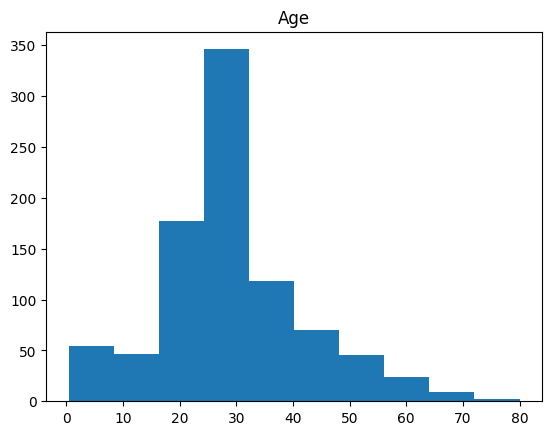

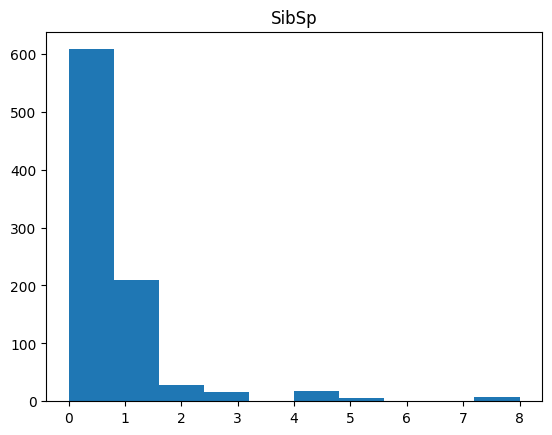

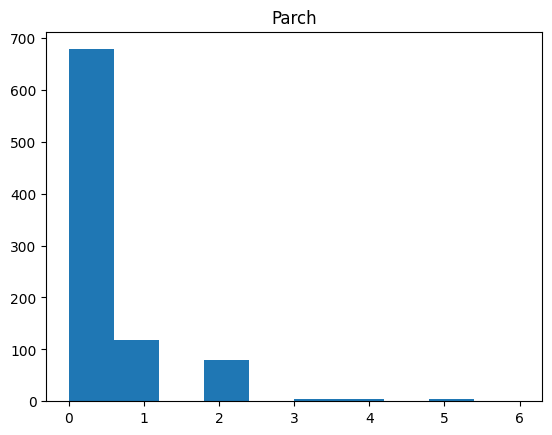

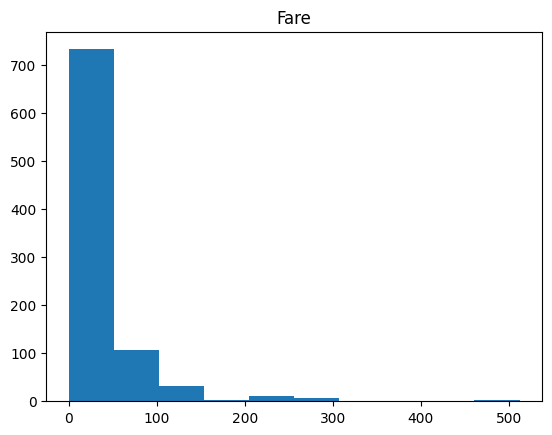

In [10]:
for i in ["Age", "SibSp", "Parch", "Fare"]:
    plt.hist(train_dataset[i])
    plt.title(i)
    plt.show()

# TODO: plt.show in a nice grid

We can see that Fare, SibSp and Parch are not normally distributed so we might need to normalize these values whereas the Age is normally distributed and does not need normalization for now. 

### Normalizing dataset

The fare value will be normalized because its distribution is not normal as we can see from the histograms above and that might result in...

In [11]:
# TODO: search the titles in the names and add more features like that
# TODO: continue writing the statement above
# TODO: prvo normaliziraj fare, a onda pri sljedećem treniranju i godine za svaki slučaj

min_max_scaler = preprocessing.MinMaxScaler()
cols = ["Fare", "SibSp", "Parch"]
for col in cols:
    train_dataset[col] = min_max_scaler.fit_transform(np.array(train_dataset[col]).reshape(-1, 1))
    test_dataset[col] = min_max_scaler.transform(np.array(test_dataset[col]).reshape(-1, 1))
    
test_dataset.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0.000,0.000000,0.015282,1
1,3,0,47.0,0.125,0.000000,0.013663,2
2,2,1,62.0,0.000,0.000000,0.018909,1
3,3,1,27.0,0.000,0.000000,0.016908,2
4,3,0,22.0,0.125,0.166667,0.023984,2
5,3,1,14.0,0.000,0.000000,0.018006,2
6,3,0,30.0,0.000,0.000000,0.014891,1
7,2,1,26.0,0.125,0.166667,0.056604,2
8,3,0,18.0,0.000,0.000000,0.014110,0
9,3,1,21.0,0.250,0.000000,0.047138,2


### Splitting the dataset
The dataset will be split into a train and validation subsets. Firstly, the examples and labels need to be separated. 

In [12]:
y = train_dataset["Survived"]
X = train_dataset.drop(["Survived"], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

### Grid Search

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, verbose=1)

# Create a GridSearchCV object with the specified hyperparameter grid and model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

# Print the best hyperparameters and corresponding score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best hyperparameters:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best score:  0.8300797793755541


### Training the models
Different approaches will be made to training the model and finally the approach with the highest accuracy will be chosen. 

In [16]:
# Training the random forest classifier
clf = RandomForestClassifier(
    n_estimators=grid_search.best_params_['n_estimators'], 
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf']
    ).fit(X=X, y=y)

# TODO: Try grid search, CV fold and different approaches to check for overfitting, underfitting or finding the optimal weights. 

In [17]:
predictions = clf.predict(X_val)
accuracy = accuracy_score(y_true=y_val, y_pred=predictions)
print(f"Validation accuracy for the chosen model is {accuracy}%.")

Validation accuracy for the chosen model is 0.8547486033519553%.


### Submitting results
Now the predictions are saved in the appropriate format so that they can be uploaded to Kaggle. 

In [18]:
test_dataset.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0.000,0.000000,0.015282,1
1,3,0,47.0,0.125,0.000000,0.013663,2
2,2,1,62.0,0.000,0.000000,0.018909,1
3,3,1,27.0,0.000,0.000000,0.016908,2
4,3,0,22.0,0.125,0.166667,0.023984,2
5,3,1,14.0,0.000,0.000000,0.018006,2
6,3,0,30.0,0.000,0.000000,0.014891,1
7,2,1,26.0,0.125,0.166667,0.056604,2
8,3,0,18.0,0.000,0.000000,0.014110,0
9,3,1,21.0,0.250,0.000000,0.047138,2


In [19]:
submission_preds = clf.predict(test_dataset)
submission_df = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": submission_preds
})

submission_df.to_csv("submission.csv", index=False)